<a href="https://colab.research.google.com/github/amoakoh22/Renko-Chart-Engineering/blob/main/Renko_Chart_Engineers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Renko Chart with Wicks:
                         open     close      high       low     type  \
date                                                                   
2020-10-16 00:15:00  1906.531  1905.531  1906.698  1904.801  bearish   
2020-10-16 00:45:00  1905.531  1906.531  1907.409  1905.070  bullish   
2020-10-16 01:00:00  1906.531  1907.531  1910.586  1906.123  bullish   
2020-10-16 01:00:00  1907.531  1908.531  1907.531  1907.531  bullish   
2020-10-16 02:00:00  1908.531  1907.531  1910.070  1905.760  bearish   

                     wick_length  
date                              
2020-10-16 00:15:00        0.730  
2020-10-16 00:45:00        0.878  
2020-10-16 01:00:00        3.055  
2020-10-16 01:00:00       -1.000  
2020-10-16 02:00:00        1.771  

Top 10 Extreme Wicks:
                         open      high       low     close  wick_length
d

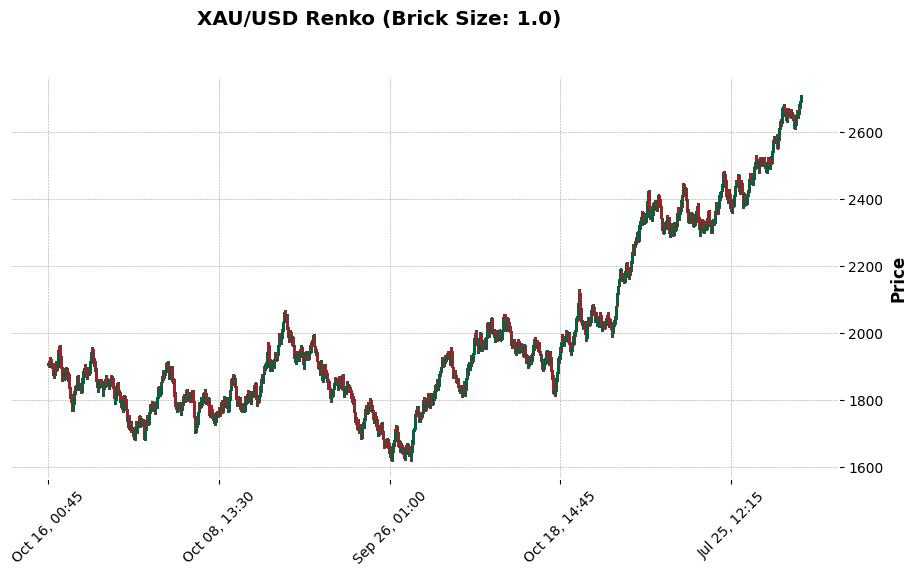

In [16]:
# Environment Setup
!pip install mplfinance pandas numpy matplotlib
from google.colab import drive
drive.mount('/content/drive')

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

# Data Loading & Cleaning
file_path = '/content/drive/MyDrive/PCP Dataset/XAUUSD_M15.csv'
ohlc_data = pd.read_csv(file_path, sep='\t')

# Clean and standardize column names
ohlc_data.columns = [col.strip('<>').lower() for col in ohlc_data.columns]

# Create datetime index
ohlc_data['datetime'] = pd.to_datetime(ohlc_data['date'] + ' ' + ohlc_data['time'],
                                      format='%Y.%m.%d %H:%M:%S')
ohlc_data = ohlc_data.set_index('datetime').sort_index()

# Select relevant columns (excluding volume)
ohlc_data = ohlc_data[['open', 'high', 'low', 'close']]

# Custom Renko Generator with Wick Tracking
def generate_renko(df, brick_size=1.0):
    renko_data = []
    current_price = df.iloc[0]['close']
    current_high = df.iloc[0]['high']
    current_low = df.iloc[0]['low']

    for index, row in df.iterrows():
        current_high = max(current_high, row['high'])
        current_low = min(current_low, row['low'])

        # Upward brick
        while row['close'] >= current_price + brick_size:
            new_close = current_price + brick_size
            renko_data.append({
                'date': index,
                'open': current_price,
                'close': new_close,
                'high': current_high,
                'low': current_low,
                'type': 'bullish'
            })
            current_price = new_close
            current_high = new_close
            current_low = new_close

        # Downward brick
        while row['close'] <= current_price - brick_size:
            new_close = current_price - brick_size
            renko_data.append({
                'date': index,
                'open': current_price,
                'close': new_close,
                'high': current_high,
                'low': current_low,
                'type': 'bearish'
            })
            current_price = new_close
            current_high = new_close
            current_low = new_close

    return pd.DataFrame(renko_data).set_index('date')

# Generate Renko Chart
brick_size = 1.0  # Adjust based on volatility
renko_df = generate_renko(ohlc_data, brick_size)

# Calculate Wick Lengths
renko_df['wick_length'] = np.where(
    renko_df['type'] == 'bullish',
    renko_df['high'] - renko_df['close'],
    renko_df['close'] - renko_df['low']
)

# Display Results
print("Renko Chart with Wicks:")
print(renko_df.head())
print("\nTop 10 Extreme Wicks:")
print(renko_df.nlargest(10, 'wick_length')[['open', 'high', 'low', 'close', 'wick_length']])

# Visualization
mpf.plot(renko_df, type='renko', style='charles',
         title=f'XAU/USD Renko (Brick Size: {brick_size})',
         figratio=(20, 10))

Visualizing the last **300 bricks** in our dataset

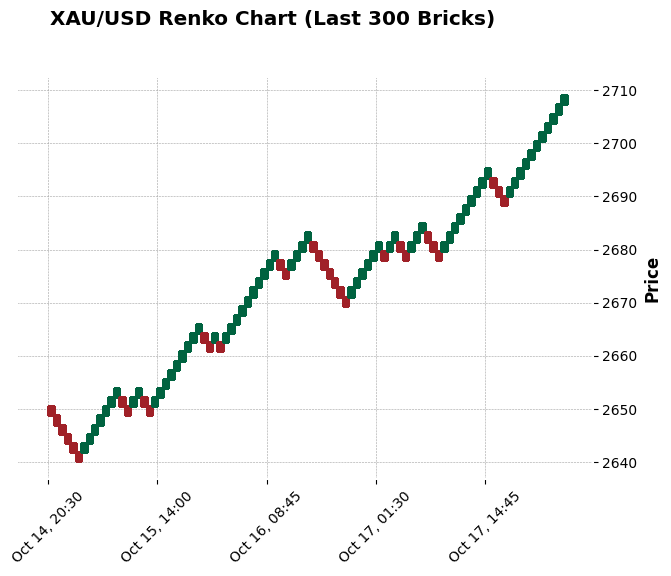

In [17]:
subset_renko = renko_df.tail(300)
mpf.plot(subset_renko, type='renko', style='charles',
         title='XAU/USD Renko Chart (Last 300 Bricks)', ylabel='Price')